In [1]:
import csv
import cv2
import numpy as np
import keras
from scipy import ndimage

lines=[]
with open('data/data/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    i_have_seen_firstline=False
    for line in reader:
        if i_have_seen_firstline:
            lines.append(line)
        else:
            i_have_seen_firstline = True

images=[]
measurements=[]
for line in lines:
    source_path = line[0]
    filename= source_path.split('/')[-1]
    current_path = 'data/data/IMG/' + filename
    #image=cv2.imread(current_path)
    image = ndimage.imread(current_path)
    images.append(image)
    measurement=float(line[3])
    measurements.append(measurement)
    
#
augment_by_flipping=False
if augment_by_flipping:
    augmented_images, augmented_measurements = [],[]
    for image,measurement in zip(images, measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)
else:
    augmented_images, augmented_measurements =images,measurements
    
    

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is de

In [2]:
print(X_train.shape)
print(np.mean(y_train**2* 180/3.14*16)) # convert from rad to deg and then to steerin-WEEL-angle 


(8036, 160, 320, 3)
15.238557501330307


In [3]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

model=Sequential()
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
cropping= True
if cropping:
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))
#model.add(Flatten())
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(90, 320, 3), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(120))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Activation('relu'))

model.add(Dense(1))

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 6)        456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 6)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 32)       4832      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46816)             0         
__________

In [4]:
###########

model.compile(loss='mse',optimizer='adam')
history_object =  model.fit(X_train,y_train,validation_split=0.2,shuffle=True, epochs=4, verbose=1)

Train on 6428 samples, validate on 1608 samples
Epoch 1/4
6428/6428 [==============================] - 10s 1ms/step - loss: 0.0248 - val_loss: 0.0104
Epoch 2/4
6428/6428 [==============================] - 9s 1ms/step - loss: 0.0074 - val_loss: 0.0106
Epoch 3/4
6428/6428 [==============================] - 9s 1ms/step - loss: 0.0047 - val_loss: 0.0117
Epoch 4/4
6428/6428 [==============================] - 9s 1ms/step - loss: 0.0027 - val_loss: 0.0119


dict_keys(['loss', 'val_loss'])


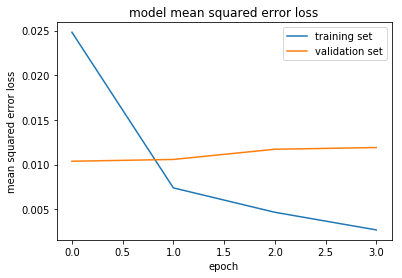

In [5]:
%matplotlib inline  


print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


##############
model.save('model.h5')